## ED22B052 Lab11_A Neural Networks Backward Propagation

#### Implement a neural network for m-samples and n-features, as we discussed in class (both FP and BP), and for N layers in the hidden layer. Split the data (you can use the log. reg. data or any other one) and train your network with 70% of the data. Use 15% for validation and test your network with the remaining 15% of data. Report the evaluation metrics for the varying number of layers in the network. Plot the training loss curves.

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('3D_printing_data.csv')

# Encode categorical features
for col in ['material', 'infill_pattern']:
    data[col] = LabelEncoder().fit_transform(data[col])

# Features and target
features = data.drop(columns=['elongation'])
target = data['elongation'].values.reshape(-1, 1)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train/val/test split: 70/15/15
x_temp, x_test, y_temp, y_test = train_test_split(features_scaled, target, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.1765, random_state=42) # 0.1765*0.85 ≈ 0.15


In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)
def relu_deriv(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)
def tanh_deriv(x):
    return 1 - np.tanh(x) ** 2


In [15]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', lr=0.01, seed=42):
        np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.lr = lr
        # Activation functions
        activations = {
            'sigmoid': (sigmoid, sigmoid_deriv),
            'relu': (relu, relu_deriv),
            'tanh': (tanh, tanh_deriv)
        }
        self.activation, self.activation_deriv = activations[activation]
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        a = X
        activations = [a]
        zs = []
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            zs.append(z)
            a = self.activation(z)
            activations.append(a)
        # Output layer (linear for regression)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        zs.append(z)
        activations.append(z)
        return activations, zs

    def backward(self, X, y, activations, zs):
        # Gradients
        m = X.shape[0]
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)
        # Output layer: MSE loss derivative
        delta = (activations[-1] - y) / m  # (batch_size, output_dim)
        grads_w[-1] = np.dot(activations[-2].T, delta)
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)
        # Hidden layers
        for l in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[l+1].T) * self.activation_deriv(zs[l])
            grads_w[l] = np.dot(activations[l].T, delta)
            grads_b[l] = np.sum(delta, axis=0, keepdims=True)
        return grads_w, grads_b

    def update(self, grads_w, grads_b):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    def train(self, X, y, X_val, y_val, epochs=200):
        train_losses, val_losses = [], []
        for epoch in range(epochs):
            activations, zs = self.forward(X)
            train_loss = mean_squared_error(y, activations[-1])
            train_losses.append(train_loss)
            # Backpropagation
            grads_w, grads_b = self.backward(X, y, activations, zs)
            self.update(grads_w, grads_b)
            # Validation loss
            val_pred = self.predict(X_val)
            val_loss = mean_squared_error(y_val, val_pred)
            val_losses.append(val_loss)
        return train_losses, val_losses

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1]


In [16]:
layer_configs = [
    [x_train.shape[1], 8, 1],           # 1 hidden layer
    [x_train.shape[1], 16, 8, 1],       # 2 hidden layers
    [x_train.shape[1], 32, 16, 8, 1],   # 3 hidden layers
]

results = {}
for config in layer_configs:
    print(f"\nTraining network with layers: {config}")
    net = NeuralNetwork(config, activation='relu', lr=0.01)
    train_loss, val_loss = net.train(x_train, y_train, x_val, y_val, epochs=200)
    y_pred = net.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    # For cross-entropy, binarize target and predictions (as in your code)
    y_test_bin = (y_test > np.median(y_train)).astype(int)
    y_pred_prob = sigmoid(y_pred)
    ce = log_loss(y_test_bin, y_pred_prob)
    results[str(config)] = {'MSE': mse, 'Cross Entropy': ce, 'train_loss': train_loss, 'val_loss': val_loss}



Training network with layers: [11, 8, 1]

Training network with layers: [11, 16, 8, 1]

Training network with layers: [11, 32, 16, 8, 1]


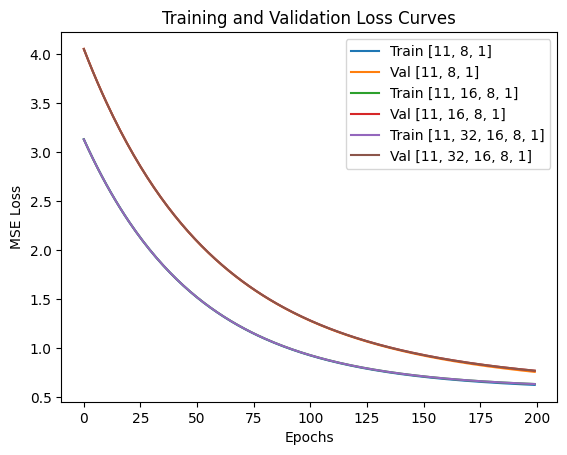

In [17]:
for config, metrics in results.items():
    plt.plot(metrics['train_loss'], label=f"Train {config}")
    plt.plot(metrics['val_loss'], label=f"Val {config}")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


In [18]:
print("Evaluation Metrics for Different Network Depths:")
print("=" * 50)
for config, metrics in results.items():
    print(f"Layers: {config}")
    print(f"  Mean Squared Error: {metrics['MSE']:.4f}")
    print(f"  Cross Entropy: {metrics['Cross Entropy']:.4f}")
    print("-" * 50)


Evaluation Metrics for Different Network Depths:
Layers: [11, 8, 1]
  Mean Squared Error: 0.8618
  Cross Entropy: 0.7410
--------------------------------------------------
Layers: [11, 16, 8, 1]
  Mean Squared Error: 0.8770
  Cross Entropy: 0.7421
--------------------------------------------------
Layers: [11, 32, 16, 8, 1]
  Mean Squared Error: 0.8769
  Cross Entropy: 0.7421
--------------------------------------------------


### The data is Approximately similar as forward propagating.